In [230]:
import numpy as np
import pandas as pd
import pickle
from statsmodels import tsa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels import multivariate
from statsmodels import regression
import scipy.stats as stats
from statsmodels.sandbox.regression import gmm
from statsmodels.sandbox.regression.gmm import GMM
import statsmodels.stats.diagnostic as smd
from statsmodels.tsa.adfvalues import mackinnonp, mackinnoncrit
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
from statsmodels.tsa.vector_ar.hypothesis_test_results import CausalityTestResults
from statsmodels.tsa.vector_ar.var_model import VAR, VARProcess, VARResults
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen, select_order
import statsmodels.tsa.arima_model as am
from statsmodels.regression.rolling import RollingOLS

from tabulate import tabulate

import datetime as dt
from dateutil.relativedelta import relativedelta
from datetime import timedelta


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MinuteLocator
from matplotlib.ticker import PercentFormatter


import os
import warnings

from scipy.optimize import minimize, brute
from arch import arch_model


warnings.filterwarnings("ignore")

In [231]:
covid_data = pd.read_csv('/Users/garik/Datathon/owid-covid-data.csv')
eu = covid_data[covid_data.continent == 'Europe']

In [232]:
countries = eu.location.unique()
deaths = []
cases = []
dates = []
for c in countries:
    temp_df = eu[eu.location == c]
    dates.append(temp_df.date.values)
    cases.append(temp_df.total_cases_per_million.values)
    deaths.append(temp_df.total_deaths_per_million.values)

In [233]:
ans1 = pd.DataFrame([dates[0],cases[0],deaths[0]]).T
ans1.columns = ['Date',countries[0] + '_Cases',countries[0] + '_Deaths']


for i in range(1,len(countries)):
    ans2 = pd.DataFrame([dates[i],cases[i],deaths[i]]).T
    ans2.columns = ['Date',countries[i] + '_Cases',countries[i] + '_Deaths']
    ans2.index = ans2['Date']
    ans1 = ans1.join(ans2,on = 'Date',rsuffix = 'r')
    
ans1 = ans1.drop(['Dater'],axis = 1)
ans1.iloc[0] = ans1.iloc[0].fillna(0)
ans1 = ans1.ffill()

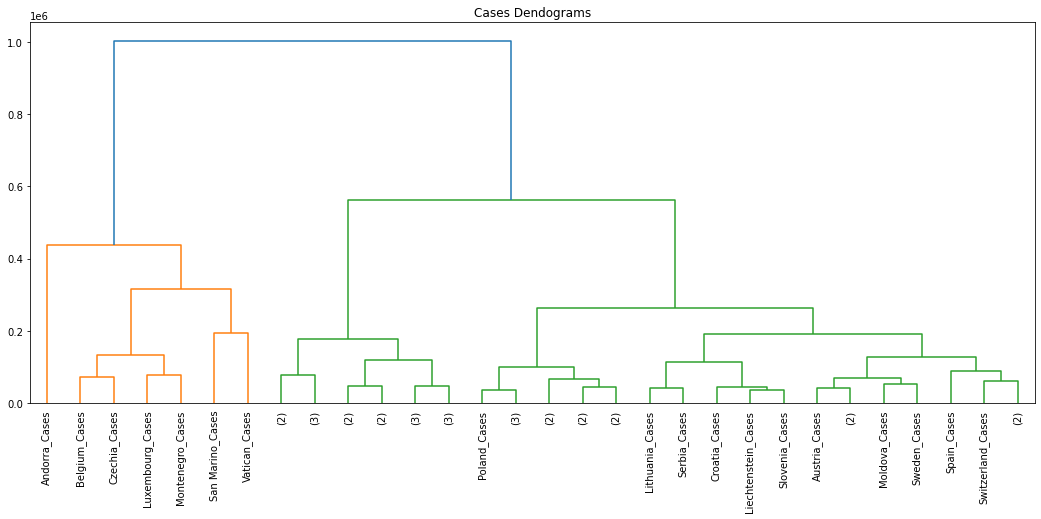

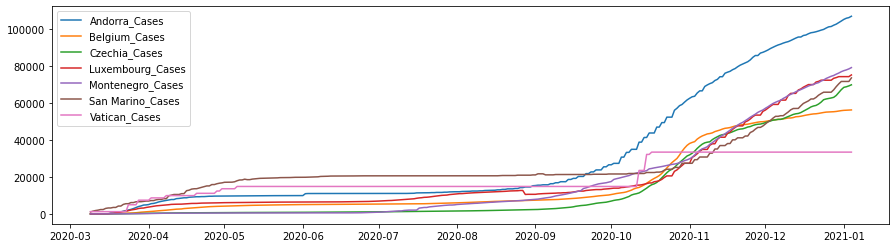

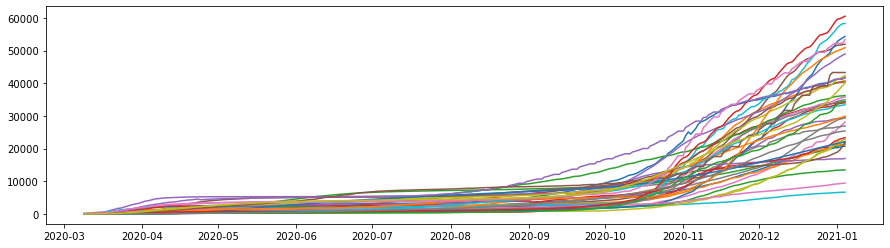

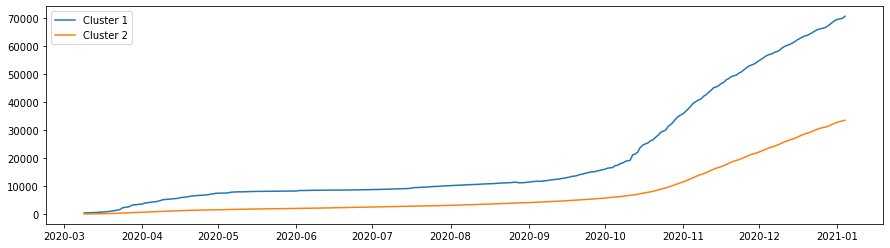

In [500]:
cl = ans1.iloc[:,1::2]
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(18, 7))
plt.title("Cases Dendograms")
dend = shc.dendrogram(shc.linkage(cl.T, method='ward'),truncate_mode='lastp',
                      orientation='top', show_leaf_counts=True,
                     no_labels = False,labels = cl.columns,leaf_rotation =90)

cluster_1 = [1,4,9,24,28,36,45]
cl_1 = list(np.array(countries[cluster_1]) + "_Cases")

cluster_2 = np.arange(0,cl.shape[1])
cluster_2= cluster_2[list(map(lambda x: x not in cluster_1,cluster_2))]
cl_2 = list(np.array(countries[cluster_2]) + "_Cases")

series_1 = ans1[list(np.array(countries[cluster_1]) + "_Cases")]

plt.figure(figsize = (15,4))
plt.plot(series_1)
plt.legend(cl_1)
plt.show()

series_2 = ans1[list(np.array(countries[cluster_2]) + "_Cases")]
plt.figure(figsize = (15,4))
plt.plot(series_2)
plt.show()

series_1.index = pd.to_datetime(ans1.Date)
series_2.index = pd.to_datetime(ans1.Date)

plt.figure(figsize = (15,4))
plt.plot(series_1.mean(axis = 1))
plt.plot(series_2.mean(axis = 1))
plt.legend(["Cluster 1","Cluster 2"])
plt.show()

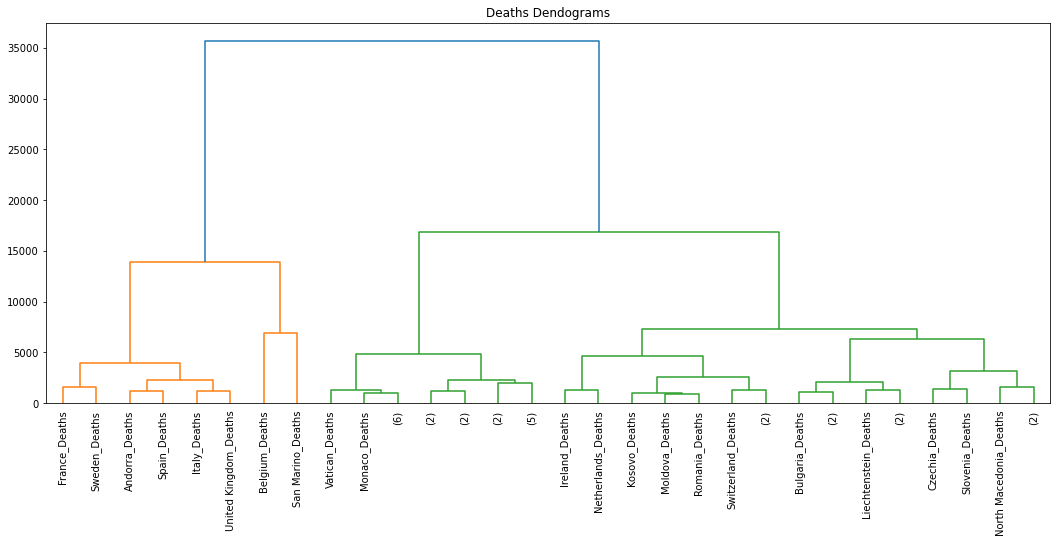

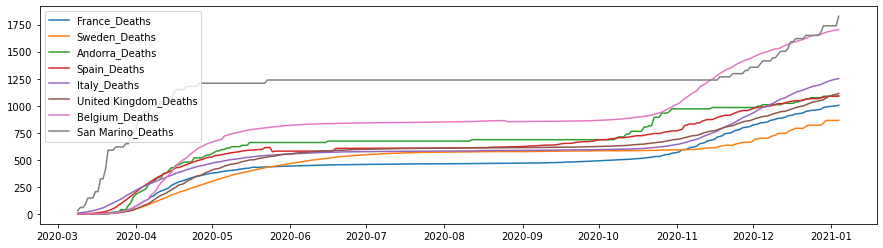

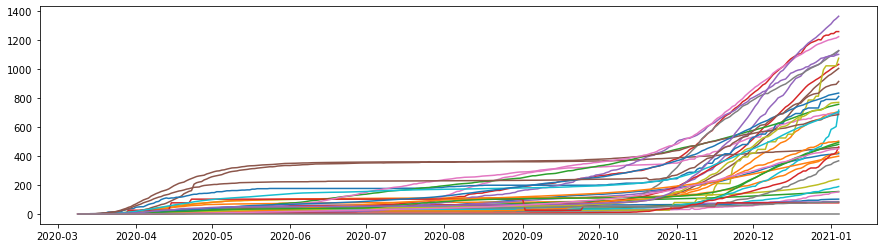

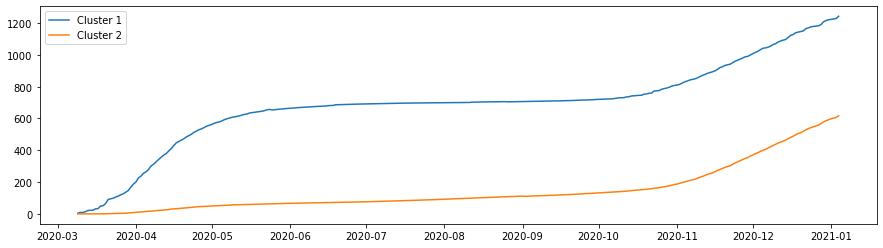

In [537]:
cl = ans1.iloc[:,2::2]
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(18, 7))
plt.title("Deaths Dendograms")
dend = shc.dendrogram(shc.linkage(cl.T, method='ward'),truncate_mode='lastp',
                      orientation='top', show_leaf_counts=True,
                     no_labels = False,leaf_rotation =90,labels = cl.columns)

cluster_1 = [13,41,1,40,19,44,4,36]
cl_1 = list(np.array(countries[cluster_1]) + "_Deaths")

cluster_2 = np.arange(0,cl.shape[1])
cluster_2= cluster_2[list(map(lambda x: x not in cluster_1,cluster_2))]
cl_2 = list(np.array(countries[cluster_2]) + "_Deaths")

series_1 = ans1[list(np.array(countries[cluster_1]) + "_Deaths")]

plt.figure(figsize = (15,4))
plt.plot(series_1)
plt.legend(cl_1)
plt.show()

series_2 = ans1[list(np.array(countries[cluster_2]) + "_Deaths")]
plt.figure(figsize = (15,4))
plt.plot(series_2)
plt.show()

series_1.index = pd.to_datetime(ans1.Date)
series_2.index = pd.to_datetime(ans1.Date)

plt.figure(figsize = (15,4))
plt.plot(series_1.mean(axis = 1))
plt.plot(series_2.mean(axis = 1))
plt.legend(["Cluster 1","Cluster 2"])
plt.show()

In [538]:
c1 = list(map(lambda x:x[:-7],cl_1))
c1

['France',
 'Sweden',
 'Andorra',
 'Spain',
 'Italy',
 'United Kingdom',
 'Belgium',
 'San Marino']

In [540]:
c2 = list(map(lambda x:x[:-7],cl_2))
c2[:4]

['Albania', 'Austria', 'Belarus', 'Bosnia and Herzegovina']

### -30,-29,...29,30 days, graphs 

In [485]:
ans1.index = pd.to_datetime(ans1.Date)

cases_data = ans1.iloc[:,1::2]
cols = cases_data.columns
cols_new = list(map(lambda x: x[:-6],cols))
cases_data.columns = cols_new

death_data = ans1.iloc[:,2::2]
cols = death_data.columns
cols_new = list(map(lambda x: x[:-7],cols))
death_data.columns = cols_new


response = pd.read_csv(path+'country_response_measures.csv',parse_dates=True)
response.name = 'response'

response.date_start = pd.to_datetime(response.date_start)
response.date_end = pd.to_datetime(response.date_end)

response = response[response.date_start > min(cases_data.index)]


def compare_measures(response,by_data = death_data, m = 'MassGatherAll',du = 30,dd = 30):

    mass = response[response.Response_measure == m]
    mass_countries = mass.Country.unique()
    
    policy_matrix = pd.DataFrame(columns = mass_countries, index= pd.to_datetime(by_data.index)).fillna(0)
    
    for c in mass_countries:
        df_temp = mass[mass.Country == c]
        try:
            policy_matrix.loc[df_temp.date_start.iloc[0],c] = 1
        except:
            pass
        try:
            policy_matrix.loc[df_temp.date_end.iloc[0],c] = -1
        except:
            pass

    policy_matrix = policy_matrix.dropna()
    changes_before_after = pd.DataFrame(index = np.arange(-dd,du+1),columns = policy_matrix.columns)
    for c in policy_matrix.columns:
        row = policy_matrix[c]
        pdate = row[row == 1].index[0]
        temp_change = by_data.loc[pdate - relativedelta(days = du):
                                  pdate + relativedelta(days = dd),c].pct_change()*100
        
        if(temp_change.shape[0] <= du+dd):
            changes_before_after.loc[0 - temp_change[:pdate].shape[0]:-1,c] = temp_change[:pdate].values
            
            changes_before_after.loc[0: 0 + temp_change[pdate:].shape[0],c] = temp_change[pdate:].values
        else:
            
            changes_before_after.loc[0 - temp_change[:pdate].shape[0]:
                                     -1,c] = temp_change[:pdate-relativedelta(days = 1)].values
            
            changes_before_after.loc[0: 0 + temp_change[pdate:].shape[0],c] = temp_change[pdate:].values
            
    return changes_before_after.replace([np.inf, -np.inf], np.nan)

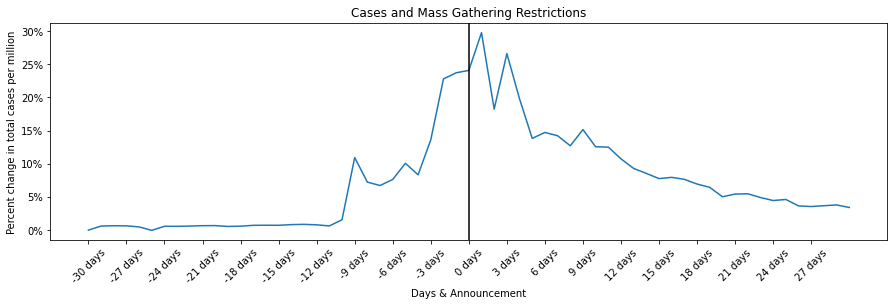

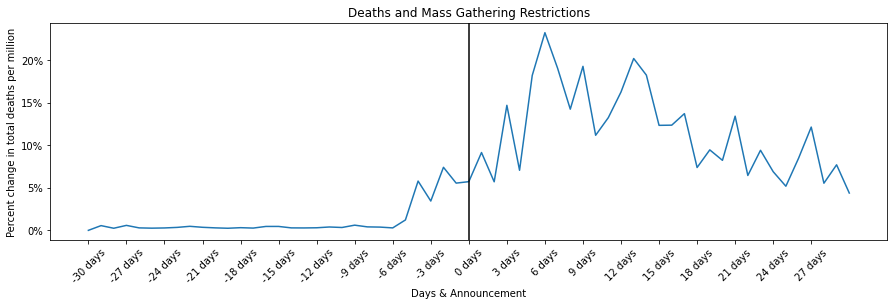

In [512]:
ev_name = 'MassGatherAll'
title = 'Mass Gathering Restrictions'
dd = 30
du = 30


md = compare_measures(response,by_data = cases_data, m = ev_name,du = du,dd = dd)
plt.figure(figsize = (15,4))
md.ffill().fillna(0).mean(axis = 1).plot()
plt.axvline(x = 0 , c = 'black')
plt.title("Cases and " + title)
plt.ylabel('Percent change in total cases per million')
plt.xlabel("Days & Announcement")
plt.xticks(ticks = np.arange(-dd,du,3),
           labels = list(map(lambda x: str(x)+ ' days',np.arange(-dd,du,3))),
          rotation=45)
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()]) 
plt.show()

plt.figure(figsize = (15,4))
md = compare_measures(response,by_data = death_data, m = ev_name,du = du,dd = dd)
md.ffill().fillna(0).mean(axis = 1).plot()
plt.axvline(x = 0 , c = 'black')
plt.title("Deaths and "+ title)
plt.ylabel('Percent change in total deaths per million')
plt.xlabel("Days & Announcement")
plt.xticks(ticks = np.arange(-dd,du,3),
           labels = list(map(lambda x: str(x)+ ' days',np.arange(-dd,du,3))),
          rotation=45)
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()]) 
plt.show()


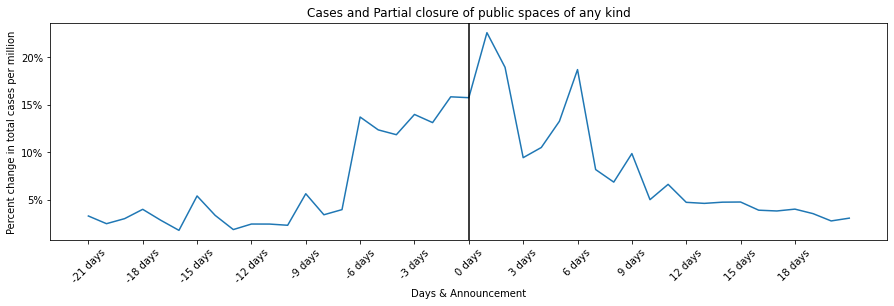

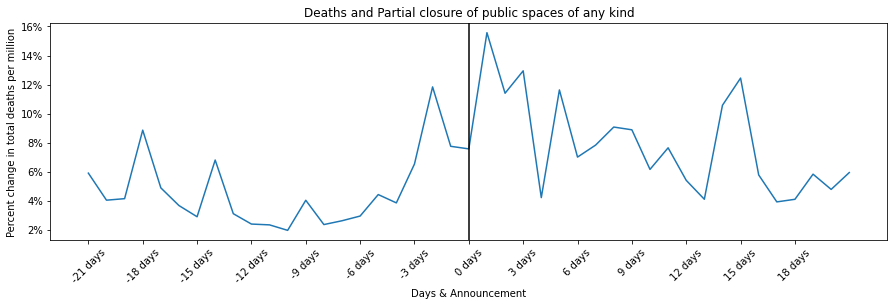

In [513]:
ev_name = 'ClosPubAnyPartial'
title = 'Partial closure of public spaces of any kind'
dd = 30
du = 30

md = compare_measures(response,by_data = cases_data, m = ev_name,du = du,dd = dd)
plt.figure(figsize = (15,4))
md.ffill().fillna(0).loc[-21:21].mean(axis = 1).plot()
plt.axvline(x = 0 , c = 'black')
plt.title("Cases and " + title)
plt.ylabel('Percent change in total cases per million')
plt.xlabel("Days & Announcement")
plt.xticks(ticks = np.arange(-21,21,3),
           labels = list(map(lambda x: str(x)+ ' days',np.arange(-21,21,3))),
          rotation=45)
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()]) 
plt.show()

plt.figure(figsize = (15,4))
md = compare_measures(response,by_data = death_data, m = ev_name,du = du,dd = dd)
md.ffill().fillna(0).loc[-21:21].mean(axis = 1).plot()
plt.axvline(x = 0 , c = 'black')
plt.title("Deaths and "+ title)
plt.ylabel('Percent change in total deaths per million')
plt.xlabel("Days & Announcement")
plt.xticks(ticks = np.arange(-21,21,3),
           labels = list(map(lambda x: str(x)+ ' days',np.arange(-21,21,3))),
          rotation=45)
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()]) 
plt.show()



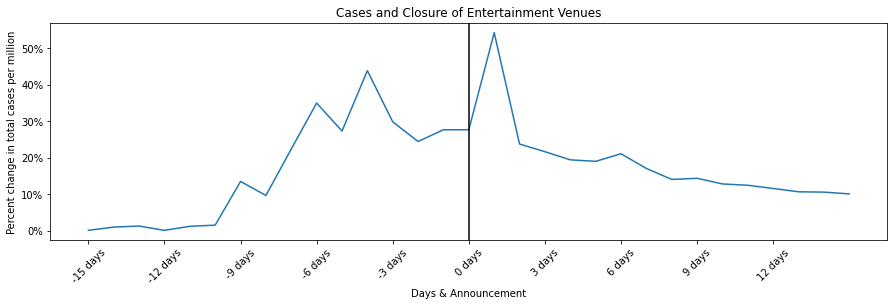

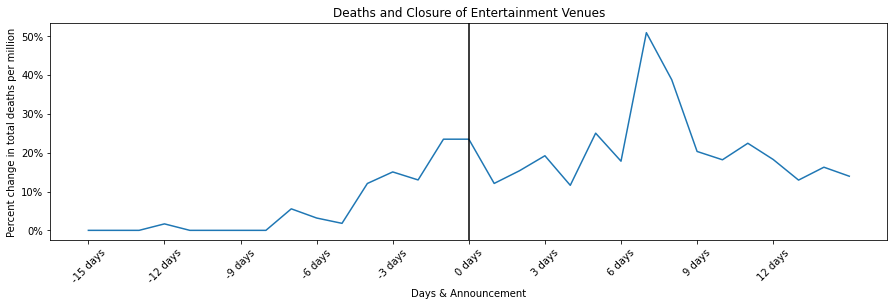

In [514]:
ev_name = 'EntertainmentVenues'
title = 'Closure of Entertainment Venues'
dd = 30
du = 30


md = compare_measures(response,by_data = cases_data, m = ev_name,du = du,dd = dd)
plt.figure(figsize = (15,4))
md.ffill().fillna(0).loc[-15:15].mean(axis = 1).plot()
plt.axvline(x = 0 , c = 'black')
plt.title("Cases and " + title)
plt.ylabel('Percent change in total cases per million')
plt.xlabel("Days & Announcement")
plt.xticks(ticks = np.arange(-15,15,3),
           labels = list(map(lambda x: str(x)+ ' days',np.arange(-15,15,3))),
          rotation=45)
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()]) 
plt.show()

plt.figure(figsize = (15,4))
md = compare_measures(response,by_data = death_data, m = ev_name,du = du,dd = dd)
md.ffill().fillna(0).loc[-15:15].mean(axis = 1).plot()
plt.axvline(x = 0 , c = 'black')
plt.title("Deaths and "+ title)
plt.ylabel('Percent change in total deaths per million')
plt.xlabel("Days & Announcement")
plt.xticks(ticks = np.arange(-15,15,3),
           labels = list(map(lambda x: str(x)+ ' days',np.arange(-15,15,3))),
          rotation=45)
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()]) 
plt.show()

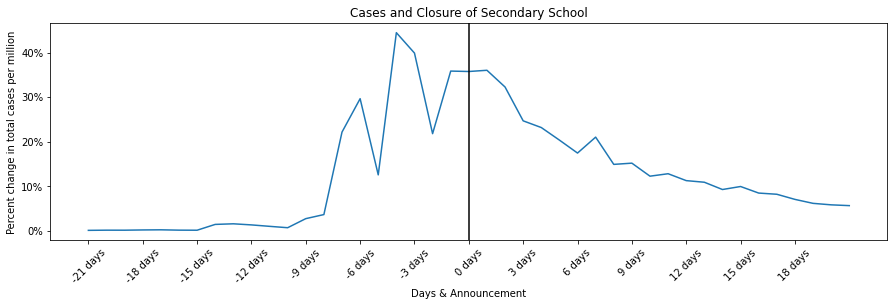

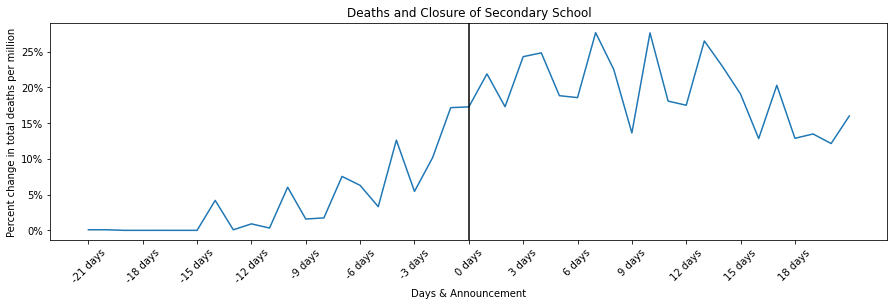

In [517]:
ev_name = 'ClosSec'
title = 'Closure of Secondary School'
dd = 21
du = 21


md = compare_measures(response,by_data = cases_data, m = ev_name,du = 30,dd = 30)
plt.figure(figsize = (15,4))
md.loc[-dd:du].ffill().fillna(0).mean(axis = 1).plot()
plt.axvline(x = 0 , c = 'black')
plt.title("Cases and " + title)
plt.ylabel('Percent change in total cases per million')
plt.xlabel("Days & Announcement")
plt.xticks(ticks = np.arange(-dd,du,3),
           labels = list(map(lambda x: str(x)+ ' days',np.arange(-dd,du,3))),
          rotation=45)
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()]) 
plt.show()

plt.figure(figsize = (15,4))
md = compare_measures(response,by_data = death_data, m = ev_name,du = 30,dd = 30)
md.loc[-dd:du].ffill().fillna(0).mean(axis = 1).plot()
plt.axvline(x = 0 , c = 'black')
plt.title("Deaths and "+ title)
plt.ylabel('Percent change in total deaths per million')
plt.xlabel("Days & Announcement")
plt.xticks(ticks = np.arange(-dd,du,3),
           labels = list(map(lambda x: str(x)+ ' days',np.arange(-dd,du,3))),
          rotation=45)
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()]) 
plt.show()

## Clusters & Measures

In [584]:
response['days_between'] = list(map(lambda x: x.days,(response['date_end']-response['date_start'])))

In [585]:
cluster_1_response = response[response['Country'].isin(c1)]
cluster_2_response = response[response['Country'].isin(c2)]

In [586]:
analysis = (pd.DataFrame(cluster_1_response.Response_measure.value_counts()/len(c1)).
 join(cluster_2_response.Response_measure.value_counts()/len(c2),rsuffix = '2'))
analysis.columns = ['Cluster 1 av measure','Cluster 2 av measure']

analysis = analysis.join(cluster_1_response.groupby('Response_measure').days_between.mean())
analysis = analysis.join(cluster_2_response.groupby('Response_measure').days_between.mean(),rsuffix = '2')
analysis.columns = ['Cluster 1 av measure','Cluster 2 av measure','Cluster 1 av days','Cluster 2 av days']

In [600]:
analysis = analysis.sort_values(by = 'Cluster 2 av measure',ascending = False)
analysis['diff_measure'] = analysis['Cluster 2 av measure'] - analysis['Cluster 1 av measure']
analysis['diff_days'] = analysis['Cluster 2 av days'] - analysis['Cluster 1 av days']

In [608]:
display(analysis.sort_values(by = 'diff_measure',ascending = False)[:10])
display(analysis.sort_values(by = 'diff_measure',ascending = False)[-10:])

,Cluster 1 av measure,Cluster 2 av measure,Cluster 1 av days,Cluster 2 av days,diff_measure,diff_days
IndoorOver100,0.125,0.578947,19.000000,46.100000,0.453947,27.100000
OutdoorOver500,0.125,0.552632,123.000000,44.578947,0.427632,-78.421053
IndoorOver50,0.250,0.526316,74.000000,53.933333,0.276316,-20.066667
ClosPrim,0.625,0.894737,98.600000,82.615385,0.269737,-15.984615
MassGatherAllPartial,0.375,0.578947,66.333333,81.312500,0.203947,14.979167
ClosHigh,0.750,0.921053,116.333333,89.000000,0.171053,-27.333333
StayHomeGen,0.250,0.421053,8.000000,40.785714,0.171053,32.785714
MassGather50Partial,0.250,0.368421,26.500000,57.400000,0.118421,30.900000
BanOnAllEventsPartial,0.125,0.236842,23.000000,55.833333,0.111842,32.833333
PrivateGatheringRestrictions,0.875,0.973684,98.333333,56.550000,0.098684,-41.783333


,Cluster 1 av measure,Cluster 2 av measure,Cluster 1 av days,Cluster 2 av days,diff_measure,diff_days
MasksMandatoryClosedSpaces,0.625,0.421053,24.000000,119.333333,-0.203947,95.333333
OutdoorOver1000,0.500,0.263158,95.000000,73.000000,-0.236842,-22.000000
MasksVoluntaryClosedSpaces,0.375,0.131579,34.666667,81.500000,-0.243421,46.833333
BanOnAllEvents,0.875,0.552632,78.500000,78.818182,-0.322368,0.318182
NonEssentialShopsPartial,0.875,0.526316,26.200000,51.625000,-0.348684,25.425000
SocialCircle,0.500,0.078947,NaN,NaN,-0.421053,NaN
StayHomeOrder,0.875,0.394737,47.428571,42.250000,-0.480263,-5.178571
Teleworking,1.000,0.447368,70.250000,72.875000,-0.552632,2.625000
StayHomeOrderPartial,0.875,0.289474,27.666667,16.000000,-0.585526,-11.666667
RegionalStayHomeOrderPartial,0.250,NaN,26.500000,NaN,NaN,NaN


In [609]:
display(analysis.sort_values(by = 'diff_days',ascending = False)[:10])
display(analysis.sort_values(by = 'diff_days',ascending = False)[-10:])

,Cluster 1 av measure,Cluster 2 av measure,Cluster 1 av days,Cluster 2 av days,diff_measure,diff_days
MasksMandatoryClosedSpaces,0.625,0.421053,24.000000,119.333333,-0.203947,95.333333
IndoorOver1000,0.250,0.263158,7.000000,65.800000,0.013158,58.800000
ClosureOfPublicTransportPartial,0.125,0.157895,28.000000,78.000000,0.032895,50.000000
MasksVoluntaryClosedSpaces,0.375,0.131579,34.666667,81.500000,-0.243421,46.833333
BanOnAllEventsPartial,0.125,0.236842,23.000000,55.833333,0.111842,32.833333
StayHomeGen,0.250,0.421053,8.000000,40.785714,0.171053,32.785714
MassGather50Partial,0.250,0.368421,26.500000,57.400000,0.118421,30.900000
RegionalStayHomeOrder,0.125,0.052632,16.000000,46.000000,-0.072368,30.000000
IndoorOver100,0.125,0.578947,19.000000,46.100000,0.453947,27.100000
MassGatherAll,1.000,0.947368,53.000000,79.350000,-0.052632,26.350000


,Cluster 1 av measure,Cluster 2 av measure,Cluster 1 av days,Cluster 2 av days,diff_measure,diff_days
ClosPubAnyPartial,1.000,1.078947,141.0,71.875000,0.078947,-69.125000
PlaceOfWorshipPartial,0.500,0.394737,119.0,46.750000,-0.105263,-72.250000
OutdoorOver500,0.125,0.552632,123.0,44.578947,0.427632,-78.421053
StayHomeGenPartial,0.125,0.131579,112.0,28.750000,0.006579,-83.250000
TeleworkingPartial,0.375,0.263158,151.0,16.000000,-0.111842,-135.000000
AdaptationOfWorkplacePartial,0.250,0.105263,115.0,NaN,-0.144737,NaN
MasksVoluntaryAllSpacesPartial,0.125,0.105263,NaN,70.666667,-0.019737,NaN
SocialCircle,0.500,0.078947,NaN,NaN,-0.421053,NaN
StayHomeRiskGPartial,0.125,0.026316,26.0,NaN,-0.098684,NaN
RegionalStayHomeOrderPartial,0.250,NaN,26.5,NaN,NaN,NaN
